Implementation of _Weight Uncertainty in Neural Networks_, Charles Blundell et al., May 2015

In [1]:
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from scipy import optimize, stats
import seaborn as sns
sns.set()
import pandas as pd

# Linear Regression

We start with the simplest possible setting: linear regression; this will make it easy to plot the model and to examine the optimization process.

In [2]:
N = 250
true_parameters = np.array([3, -2])

X = np.random.random(size=(N, 2)) * 4 - 2
X[:, 1] = 1
eps = np.random.normal(scale=0.75, size=(N,))

y = X.dot(true_parameters) + eps

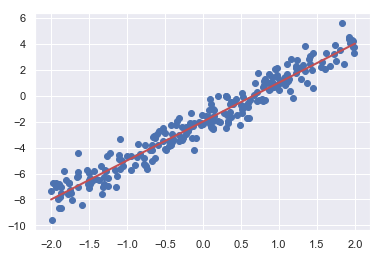

In [3]:
plt.scatter(X[:, 0], y)
plt.plot([-2, 2], [-2 * 3 - 2, 2 * 3 - 2], 'r', linewidth=2)

We should choose the proper standard deviation for the prior; if it's too low, the prior would be too strong and favor parameters close to zero. In this case we can cheat and actually check how much regularization would result in the best prior likelihood for the parameters:

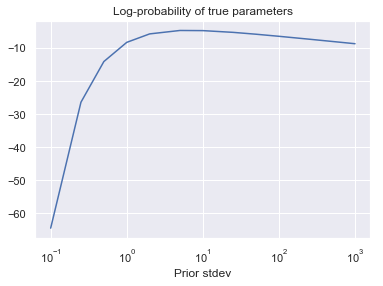

In [4]:
covs = [0.1, 0.25, 0.5, 1, 2, 5, 10, 25, 50, 100, 250, 500, 1000]
ps = [
    stats.multivariate_normal(
        mean=np.zeros(2),
        cov=c * np.eye(2)
    ).logpdf(true_parameters)
    for c in covs
]

plt.semilogx(covs, ps)
plt.xlabel('Prior stdev')
plt.title('Log-probability of true parameters')
plt.show()

We can safely pick a prior standard deviation of 2.


Short anecdote: initially I didn't know which value to choose, so I randomly chose for 0.1, for no particular reason. After I finished the implementation, the parameters found by gradient descent were not that good, but not so bad that you would think something bad was going on. Then, after some head-scratching, I checked the three components of the loss, and found that the true parameters had indeed larger likelihood, but their loss was heavily influenced by the penalty due to the prior. I ran everything with a larger prior standard deviation and everything went smoothly.

We now apply the variational method proposed in the paper, where we use Gaussians everywhere (prior, approximate posterior, and likelihood).

In [5]:
class GradientDescentOptimizer:
    def __init__(self, momentum=0.9, base_lrate=1, clip_gradient=1,
                 min_improvement=1e-3, max_steps=1000, verbose=0,
                 raise_exceptions=False):
        self.momentum = momentum
        self.base_lrate = base_lrate
        self.clip_gradient = clip_gradient
        self.min_improvement = min_improvement
        self.max_steps = max_steps
        self.verbose = verbose
        self.raise_exceptions = raise_exceptions

    def log(self, level, *message):
        if level <= self.verbose:
            print(*message)

    def minimize(self, initial, f, *f_args):
        old_gradient = None
        old_value = np.inf
        parameters = initial
        base_lrate = self.base_lrate
        best = old_value, parameters
        
        self.hist = []
        for i in range(self.max_steps):
            try:
                value, gradient = f(parameters, *f_args)
            except Exception as exc:
                if self.raise_exceptions:
                    raise
                else:
                    self.log(0, exc)
                    break

            # update best guess
            if value < best[0]:
                best = value, parameters

            # halve learning rate if function increased
            # NB: in this case, the function is approximated with monte carlo sampling
            # which means it is potentially very noisy, therefore cannot interpret
            # the value decreasing as 
            if value > old_value:
                #base_lrate *= 0.5
                pass

            # decay learning rate
            lrate = base_lrate / np.sqrt(i + 1)

            # clip gradient
            mag = np.sqrt(np.sum(gradient**2))
            if self.clip_gradient > 0 and mag > self.clip_gradient:
                gradient = gradient * self.clip_gradient / mag

            # apply momentum
            if old_gradient is not None:
                gradient = self.momentum * old_gradient + (1 - self.momentum) * gradient

            # update, log and check for stopping criterion
            parameters -= lrate * gradient

            self.hist.append((i, value, old_value - value, lrate, mag, parameters.copy()))
            self.log(2, 'IT: %6d | LLI: %14.3f | IM: %14.3e | LR: %14.3e | MAG: %14.3f - %s' % self.hist[-1])

            if i > 10 and abs(value - old_value) < self.min_improvement:
                break

            old_value, old_gradient = value, gradient

        return best

    def minimize_with_restarts(self, num_restarts, sample_initial, f, *f_args):
        best, hist = None, None
        for i in range(num_restarts):
            parameters = sample_initial()
            value, parameters = self.minimize(parameters, f, *f_args)
            if best is None or value < best[0]:
                best = value, parameters
                hist = self.hist
                
            self.log(1, '--------------------- %d - Got: %.4f - Best: %.4f' % (i + 1, value, best[0]))
            self.log(1, '----', parameters)

        self.hist = hist
        return best

In [270]:
def sample_and_loss(mu, rho, eps, X, y, regu, sigma_noise):
    ''' sample one set of parameters and compute loss and gradients
    '''
    
    sigma = np.log(1 + np.exp(rho))
    w = mu + sigma * eps
    
    log_q = -0.5 * np.log(2 * np.pi) - np.log(sigma) - (w - mu)**2 / (2 * sigma**2)
    log_p = -0.5 * np.log(2 * np.pi) - np.log(regu) - w**2 / (2 * regu**2)

    preds = X.dot(w)
    log_d = -0.5 * np.log(2 * np.pi) - np.log(sigma_noise) - (preds - y)**2 / (2 * sigma_noise**2)
    
    loss = np.sum(log_q) - np.sum(log_p) - np.sum(log_d)

    # compute gradient of loss wrt w
    dlogq_dw = -(w - mu) / sigma**2
    dlogp_dw = -w / regu**2
    dlogd_dw = np.sum(
        -X.T * (preds - y).T / sigma_noise**2,
        axis=1
    )
    dloss_dw = dlogq_dw - dlogp_dw - dlogd_dw

    # compute gradient of loss wrt mu
    dlogq_dmu = np.zeros(mu.shape)
    dlogp_dmu = dlogp_dw
    dlogd_dmu = dlogd_dw
    dloss_dmu = dlogq_dmu - dlogp_dmu - dlogd_dw
    
    # compute gradient of loss wrt rho
    dsigma_drho = np.exp(rho) / (1 + np.exp(rho))
    dw_dsigma = eps
    
    dlogq_drho = -dsigma_drho / sigma
    dlogp_drho = dlogp_dw * dw_dsigma * dsigma_drho
    dlogd_drho = dlogd_dw * dw_dsigma * dsigma_drho
    dloss_drho = dlogq_drho - dlogp_drho - dlogd_drho
    
    return loss, w, dloss_dw, dloss_dmu, dloss_drho


def compute_loss(mu, rho, X, y, regu, sigma_noise, reps=100):
    ''' approximate the loss and the gradients by monte carlo sampling 
    '''
    acc = None
    for i in range(reps):
        eps = np.random.normal(size=rho.shape[0])
        loss, w, dloss_dw, dloss_dmu, dloss_drho = sample_and_loss(
            mu, rho, eps, X, y, regu, sigma_noise
        )
        
        gradient_mu = dloss_dw + dloss_dmu
        gradient_rho = dloss_dw * eps / (1 + np.exp(-rho)) + dloss_drho
        
        res = [loss, gradient_mu, gradient_rho]
        
        if acc is None:
            acc = res
        else:
            for a, r in zip(acc, res):
                a += r

    return [a if i == 0 else a / reps for i, a in enumerate(acc)]

Check the gradients for a single sample. Averaged gradients are too noisy to be checked with finite differences.

In [23]:
mu = np.array([-0.01, 0.5])
rho = np.array([0.2, 0.1])
eps = np.array([-2, 3])
regu = 2
sigma_noise = 0.75


def gradient_check(f, x0, eps=1e-9):
    loss, gradient = f(x0)
    
    for i in range(x0.shape[0]):
        noise = np.zeros(shape=x0.shape)
        noise[i] = eps
        
        loss_neg, _ = f(x0 - noise)
        loss_pos, _ = f(x0 + noise)
        fdiff = (loss_pos - loss_neg) / (2 * eps)
        
        print('Analytical Gradient: %.4f - Finite Differences Gradient: %.4f' %(
            gradient[i], fdiff
        ))
    
        assert np.allclose(gradient[i], fdiff)


print('Checking gradient of mu')
gradient_check(
    lambda x: itemgetter(0, 3)(sample_and_loss(x, rho, eps, X, y, regu, sigma_noise)),
    x0=mu
)

print('\nChecking gradient of rho')
gradient_check(
    lambda x: itemgetter(0, 4)(sample_and_loss(mu, x, eps, X, y, regu, sigma_noise)),
    x0=rho
)

Checking gradient of mu
Analytical Gradient: -2488.8033 - Finite Differences Gradient: -2488.8031
Analytical Gradient: 2156.2910 - Finite Differences Gradient: 2156.2919

Checking gradient of rho
Analytical Gradient: 2736.1684 - Finite Differences Gradient: 2736.1684
Analytical Gradient: 3395.3184 - Finite Differences Gradient: 3395.3202


Sample random parameters, plot loss and find minimum

In [24]:
values = []
for i in range(1000):
    params = 20 * (np.random.random(size=2) - 0.5)
    ll, *_ = compute_loss(
        params, np.array([-8, -8]), X, y, 2, 0.75
    )
    ll = np.log(ll)
    values.append((params, ll))


aa = np.array([(x, y, z) for (x, y), z in values])
min_w0, min_w1, min_loss = aa[aa[:, 2].argmin()]
print('Minimum loss: %.4f at (%.4f, %.4f)' % (np.exp(min_loss), min_w0, min_w1))

Minimum loss: 346.2275 at (2.9631, -2.3887)


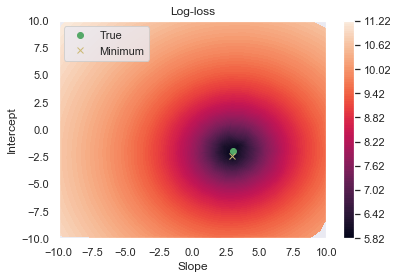

In [25]:
plt.tricontourf(aa[:, 0], aa[:, 1], aa[:, 2], levels=100)
plt.plot(3, -2, 'o', color='g', label='True')
plt.plot(min_w0, min_w1, 'x', color='y', label='Minimum')
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.colorbar()
plt.title('Log-loss')
plt.legend(loc='upper left')
plt.show()

The variance of the loss estimate depends on the value of $\rho$: 

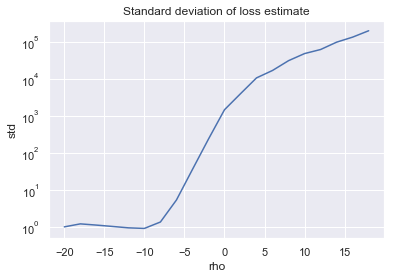

In [26]:
all_losses = []
for rho in range(-20, 20, 2):
    lss = [
        compute_loss(mu, np.array([rho, rho]), X, y, regu, sigma_noise, reps=1)[0]
        for _ in range(100)
    ]
    all_losses.append((rho, np.mean(lss), np.std(lss)))
all_losses = np.array(all_losses)

plt.semilogy(all_losses[:, 0], all_losses[:, 2])
plt.xlabel('rho')
plt.ylabel('std')
plt.title('Standard deviation of loss estimate')
plt.show()

Now we can optimize the parameters using gradient descent. We will start training with $\mu$ and $\rho$ sampled from a $\mathcal{N}(0,1)$; as shown in the previous plot, this setting of $\rho$ will result in extremely noisy estimates of the loss and its gradients. Surprisingly, however, this noise does not hinder the optimization process. Following, we will show three different optimization settings:


- Setting A: approximate loss and gradients by repeatedly sampling from the posterior; you would expect a large number of samples to yield a more accurate estimation. Do not use momentum
- Setting B: compute loss and gradients based on a single sample, but use high momentum to downplay the influence of noise;
- Setting C: compute loss and gradients based on a single sample, and do not use momentum.

In [215]:
def do_training(num_samples, momentum):
    ''' num_samples: how many samples to use to approximate loss and gradients
        momentum: momentum to apply during gradient descent
    '''
    def target_f(parameters):
        param_count = len(parameters) // 2
        mu, rho = parameters[:param_count], parameters[param_count:]

        loss, gradient_mu, gradient_rho = compute_loss(
            mu, rho, X, y, regu=2, sigma_noise=0.75,
            reps=num_samples
        )

        gradient = np.zeros(2 * param_count)
        gradient[:param_count] = gradient_mu
        gradient[param_count:] = gradient_rho

        return loss, gradient
    
    opt = GradientDescentOptimizer(
        base_lrate=0.1,
        momentum=momentum,
        verbose=0,
        min_improvement=1e-4,
        raise_exceptions=True,
        max_steps=int(1e4),
    )

    loss, parameters = opt.minimize_with_restarts(
        5,
        lambda: np.random.normal(size=4),
        target_f
    )

    print('Best loss %.4f with parameters %s' % (loss, parameters))
    return opt.hist

In [305]:
%time hist_a = do_training(num_samples=1000, momentum=0)

Best loss 294.4617 with parameters [ 2.99434417 -1.97941816 -3.10711273 -3.01815307]
CPU times: user 12min 3s, sys: 4.94 s, total: 12min 8s
Wall time: 12min 5s


In [306]:
%time hist_b = do_training(num_samples=1, momentum=0.99)

Best loss 292.9935 with parameters [ 3.00614036 -1.97390134 -1.67785822 -1.67970754]
CPU times: user 11.8 s, sys: 88.5 ms, total: 11.8 s
Wall time: 11.8 s


In [307]:
%time hist_c = do_training(num_samples=1, momentum=0.)

Best loss 289.8123 with parameters [ 3.00589855 -1.98757439 -2.15342129 -2.03694639]
CPU times: user 11.7 s, sys: 64.8 ms, total: 11.8 s
Wall time: 11.7 s


In [308]:
true_loss, *_ = compute_loss(true_parameters, np.array([-8, -8]), X, y, regu=2, sigma_noise=0.75, reps=100)
true_loss

307.1005492568045

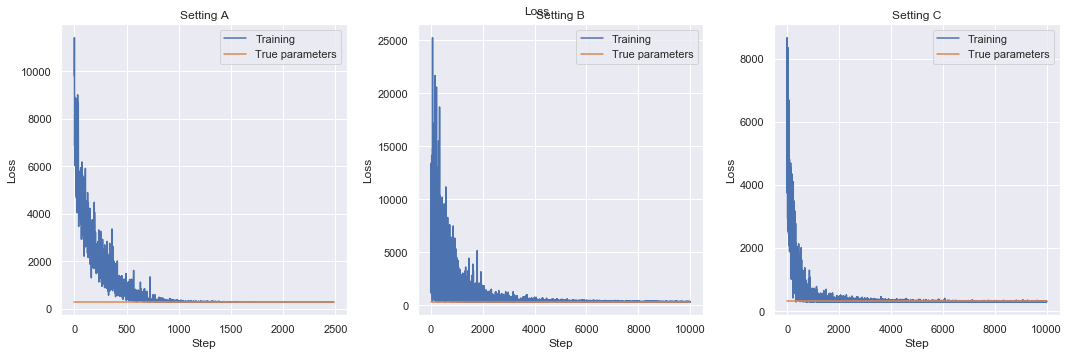

In [315]:
def plot_loss(hist):
    plt.plot([x[1] for x in hist], label='Training')
    plt.plot([0, len(hist)], [true_loss, true_loss], label='True parameters')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')


plt.figure(figsize=(15, 5))
plt.suptitle('Loss')

plt.subplot(1, 3, 1)
plt.title('Setting A')
plot_loss(hist_a)

plt.subplot(1, 3, 2)
plt.title('Setting B')
plot_loss(hist_b)

plt.subplot(1, 3, 3)
plt.title('Setting C')
plot_loss(hist_c)

plt.tight_layout()
plt.show()

Notice the different scale in the $x$ and $y$ axes!

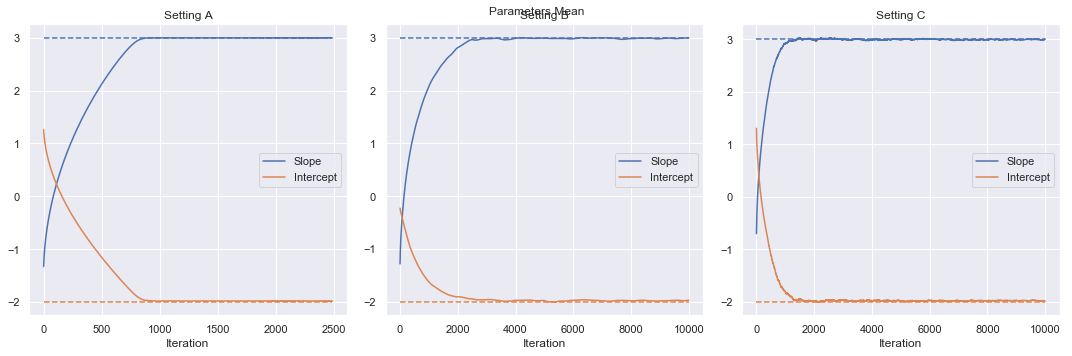

In [319]:
def plot_parameters_mean(hist):
    plt.plot([x[-1][0] for x in hist], label='Slope', color='C0')
    plt.plot([0, len(hist)], [true_parameters[0], true_parameters[0]], '--', color='C0')
    plt.plot([x[-1][1] for x in hist], label='Intercept', color='C1')
    plt.plot([0, len(hist)], [true_parameters[1], true_parameters[1]], '--', color='C1')
    plt.xlabel('Iteration')
    plt.legend()

    
plt.figure(figsize=(15, 5))
plt.suptitle('Parameters Mean')

plt.subplot(1, 3, 1)
plt.title('Setting A')
plot_parameters_mean(hist_a)

plt.subplot(1, 3, 2)
plt.title('Setting B')
plot_parameters_mean(hist_b)

plt.subplot(1, 3, 3)
plt.title('Setting C')
plot_parameters_mean(hist_c)

plt.tight_layout()
plt.show()

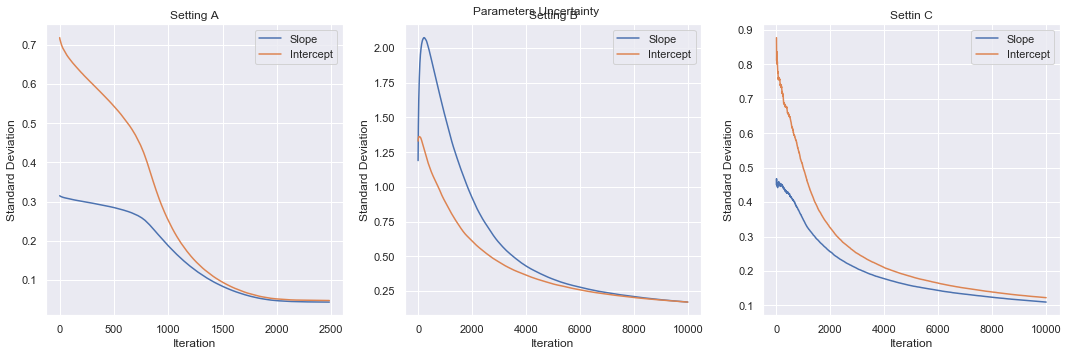

In [318]:
def plot_parameters_sigma(hist):
    plt.plot([np.log(1 + np.exp(x[-1][2])) for x in hist], label='Slope', color='C0')
    plt.plot([np.log(1 + np.exp(x[-1][3])) for x in hist], label='Intercept', color='C1')
    plt.legend()
    plt.ylabel('Standard Deviation')
    plt.xlabel('Iteration')
    
    
plt.figure(figsize=(15, 5))
plt.suptitle('Parameters Uncertainty')

plt.subplot(1, 3, 1)
plt.title('Setting A')
plot_parameters_sigma(hist_a)

plt.subplot(1, 3, 2)
plt.title('Setting B')
plot_parameters_sigma(hist_b)

plt.subplot(1, 3, 3)
plt.title('Settin C')
plot_parameters_sigma(hist_c)

plt.tight_layout()
plt.show()

Observations:

 - Method A takes much longer wall clock time, but requires much fewer parameter updates
 - At the beginning, the gradient updates are dominated by changes in the parameters mean
 - Significant updates in the parameters uncertainty only happen when the means have converged (notice the change in slope)
 - Most of the updates are spent on decreasing $\rho$, while keeping the means at the same values.
 - $\rho$ has great influence on the noise of the loss function and gradients)

Notice that the solutions obtained are different from true posterior, since in that case the parameters are usually correlated, whereas in this approximation they are forcefully independent. The mean parameters, however, are very close to the true ones. For reference, the parameters found by the traditional exact solution to linear regression, and their loss, are:

In [289]:
exact_weights = np.linalg.inv(X.T.dot(X) + 2 * np.eye(2)).dot(X.T).dot(y)
exact_loss, *_ = compute_loss(exact_weights, np.array([-8, -8]), X, y, regu=2, sigma_noise=0.75, reps=1)
exact_weights, exact_loss

(array([ 2.97757599, -1.96496295]), 306.83079509939506)

# Neural networks with Tensorflow

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((-1, 28 * 28))
x_test = x_test.reshape((-1, 28 * 28))

mux, stdx = x_train.mean(), x_train.std()
x_train = (x_train - mux) / stdx
x_test = (x_test - mux) / stdx

In [16]:
class BayesByBackpropNeuralNetwork:
    ''' simple feed-forward neural network for classification
        with fully connected layers and relu activation
        (softmax at the end)
    '''
    def __init__(self, tf_session, layer_sizes, weights_prior_1,
                 weights_prior_2, weights_prior_pi):
        
        self.layer_sizes = layer_sizes
        self.sess = tf_session
        self.weights_prior_1 = weights_prior_1
        self.weights_prior_2 = weights_prior_2
        self.weights_prior_pi = weights_prior_pi
    
    def make_weights(self, size_in, size_out):
        # we keep mu's and rho's as vectors to simplify the computations of loss and gradients
        mu_w = tf.Variable(tf.random_normal([size_in * size_out]))
        mu_b = tf.Variable(tf.random_normal([size_out]))
        
        rho_w = tf.Variable(tf.random_normal([size_in * size_out]))
        rho_b = tf.Variable(tf.random_normal([size_out]))
        
        eps_w = tf.random.normal([size_in * size_out])
        eps_b = tf.random.normal([size_out])
        
        sigma_w = tf.log(1 + tf.exp(rho_w))
        sigma_b = tf.log(1 + tf.exp(rho_b))
        
        weights = mu_w + eps_w * sigma_w
        bias = mu_b + eps_b * sigma_b
        
        return (
            (weights, bias),
            (mu_w, mu_b),
            (rho_w, rho_b),
            (sigma_w, sigma_b),
            (eps_w, eps_b)
        )
        
    def build(self):
        self.net_input = tf.placeholder(tf.float32, shape=(None, self.layer_sizes[0]))
        
        # build the network
        prev = self.net_input
        all_params, all_mus, all_rhos, all_sigmas, all_eps = [], [], [], [], []
        for i in range(1, len(self.layer_sizes)):
            size_in, size_out = self.layer_sizes[i - 1], self.layer_sizes[i]
            (weights, bias), mus, rhos, sigmas, eps = self.make_weights(size_in, size_out)
            
            activation = tf.nn.relu if i < len(self.layer_sizes) - 1 else tf.nn.softmax
            weights_matrix = tf.reshape(weights, shape=(size_in, size_out))
            prev = activation(tf.matmul(prev, weights_matrix) + bias)
            
            all_params.extend((weights, bias))
            all_mus.extend(mus)
            all_rhos.extend(rhos)
            all_sigmas.extend(sigmas)
            all_eps.extend(eps)
        
        # compute output, predictions and accuracy
        self.class_labels = tf.placeholder(tf.int32, shape=(None,))
        self.labels = tf.one_hot(self.class_labels, depth=self.layer_sizes[-1])
        self.net_output_proba = prev
        self.net_output_class = tf.math.argmax(self.net_output_proba, axis=1)
        self.op_accuracy, self.op_accuracy_op = tf.metrics.accuracy(self.class_labels, self.net_output_class)
        
        # compute_loss
        def logpdf_gaussian(x, mu, sigma):
            ''' log probability of sampling a vector x from a multivariate Gaussian
            with mean mu and diagonal covariance sigma (sigma is the diagonal)    
            '''
            return (
                - x.get_shape().as_list()[0] * np.log(2 * np.pi) / 2
                - tf.reduce_sum(tf.log(sigma)) / 2
                - tf.reduce_sum((x - mu)**2 / sigma) / 2
            ) / x.get_shape().as_list()[0]  # take mean to ease loss interpretation
        
        # log of variational posterior q(w | theta)
        self.logq = tf.reduce_mean([
            logpdf_gaussian(param, mu, sigma)
            for param, mu, sigma in zip(all_params, all_mus, all_sigmas)
        ])
        
        # log of prior
        self.logp = tf.reduce_mean([
            #self.weights_prior_pi * logpdf_gaussian(param, 0, self.weights_prior_1)
            #+ (1 - self.weights_prior_pi) * logpdf_gaussian(param, 0, self.weights_prior_2)
            logpdf_gaussian(param, 0, self.weights_prior_1)
            for param in all_params
        ])
        
        # log of likelihood, our old friend cross-entropy
        self.logd = tf.reduce_mean(self.labels * tf.log(self.net_output_proba + 1e-12))
        
        # combined loss
        self.op_loss = self.logq - self.logd - self.logp
        
        # compute gradients
        all_gradient_mus = [
            tf.gradients(self.op_loss, mu)[0] + tf.gradients(self.op_loss, params)[0]
            for params, mu in zip(all_params, all_mus)
        ]
        
        all_gradients_rho = [
            tf.gradients(self.op_loss, params)[0]
            + tf.gradients(self.op_loss, rho)[0] * eps / (1 + tf.exp(-rho))
            for params, eps, rho in zip(all_params, all_eps, all_rhos)
        ]
        
        # optimize
        gradients_and_vars = list(
            zip(all_gradient_mus, all_mus)
        ) + list(
            zip(all_gradients_rho, all_rhos)
        )
        
        self.opt = tf.train.AdamOptimizer()
        self.op_minimize = self.opt.apply_gradients(gradients_and_vars)
        
        return self
    
    def train_on_batch(self, batch_x, batch_y):
        loss, acc, logq, logp, logd, *_ = self.sess.run([
            self.op_loss, self.op_accuracy_op, self.logq,
            self.logp, self.logd, self.op_accuracy, self.op_minimize
        ], feed_dict={
            self.net_input: batch_x,
            self.class_labels: batch_y,
        })
        
        return loss, acc, logq, logp, logd
    
    def evaluate_on_batch(self, batch_x, batch_y):
        loss, acc, logq, logp, logd, *_ = self.sess.run([
            self.op_loss, self.op_accuracy_op, self.logq,
            self.logp, self.logd, self.op_accuracy
        ], feed_dict={
            self.net_input: batch_x,
            self.class_labels: batch_y,
        })
        
        return loss, acc, logq, logp, logd
    
    def evaluate(self, X, y, bsize=32):
        metrics = [self.evaluate_on_batch(X[b:b+bsize], y[b:b+bsize])
                   for b in range(0, len(X), bsize)]
        return tuple(np.mean(metrics, axis=0))
    
    def log_progress(self, epoch, num_epochs, batch_start, num_samples, bsize, metrics):
        spinner = '\|/-\|/-'
        loss, acc, logq, logp, logd = metrics
        print('\r%s | Epoch %3d - %7d / %d | Acc.: %.4f - '
              'Loss: %.4f (logQ: %.4f | logP: %.4f | logD: %.4f)%s' % (
            spinner[(batch_start // bsize) % len(spinner)],
            epoch, batch_start, num_samples, acc, loss, logq, logp, logd, ' ' * 5
        ), end='')
    
    def log_validation_progress(self, epoch, val_metrics):
        loss, acc, logq, logp, logd = val_metrics
        print('\rEpoch %3d - Val. Acc.: %.4f - Val. Loss: %.4f '
              '(logQ: %.4f | logP %.4f | logD: %.4f) %s' % (
            epoch, acc, loss, logq, logp, logd, ' ' * 15
        ))
    
    def train(self, X, y, bsize=32, epochs=1, validation_data=None):
        for epoch_idx in range(epochs):
            perm = np.random.permutation(X.shape[0])
            X, y = X[perm], y[perm]
            
            for batch_start in range(0, len(X), bsize):
                metrics = self.train_on_batch(
                    X[batch_start:batch_start+bsize],
                    y[batch_start:batch_start+bsize],
                )
                
                self.log_progress(epoch_idx + 1, epochs, batch_start,
                                  len(X), bsize, metrics)
            
            if validation_data:
                val_metrics = self.evaluate(*validation_data, bsize)
                self.log_validation_progress(epoch_idx + 1, val_metrics)


with tf.Session() as sess:
    bbnn = BayesByBackpropNeuralNetwork(
        sess, layer_sizes=[28 * 28, 1200, 10],
        weights_prior_1=10.0,
        weights_prior_2=0.01,
        weights_prior_pi=0.5
    ).build()
    
    sess.run([
        tf.global_variables_initializer(),
        tf.local_variables_initializer(),
    ])

    bbnn.train(
        x_train, y_train,
        bsize=32,
        epochs=600,
        validation_data=(x_test, y_test)
    )

Epoch   1 - Val. Acc.: 0.2910 - Val. Loss: 1.6397 (logQ: -1.0404 | logP -1.0285 | logD: -1.6516)                  
Epoch   2 - Val. Acc.: 0.4006 - Val. Loss: 1.2182 (logQ: -1.0356 | logP -1.0247 | logD: -1.2291)                  
Epoch   3 - Val. Acc.: 0.4674 - Val. Loss: 1.0580 (logQ: -1.0386 | logP -1.0230 | logD: -1.0736)                  
Epoch   4 - Val. Acc.: 0.5101 - Val. Loss: 0.9432 (logQ: -1.0436 | logP -1.0221 | logD: -0.9647)                  
Epoch   5 - Val. Acc.: 0.5402 - Val. Loss: 0.9033 (logQ: -1.0419 | logP -1.0211 | logD: -0.9241)                  
Epoch   6 - Val. Acc.: 0.5648 - Val. Loss: 0.7738 (logQ: -1.0471 | logP -1.0209 | logD: -0.8000)                  
Epoch   7 - Val. Acc.: 0.5887 - Val. Loss: 0.6661 (logQ: -1.0468 | logP -1.0202 | logD: -0.6926)                  
Epoch   8 - Val. Acc.: 0.6088 - Val. Loss: 0.6192 (logQ: -1.0442 | logP -1.0194 | logD: -0.6440)                  
Epoch   9 - Val. Acc.: 0.6260 - Val. Loss: 0.5929 (logQ: -1.0453 | logP -1.0190 

Epoch  71 - Val. Acc.: 0.8276 - Val. Loss: 0.2275 (logQ: -1.0604 | logP -1.0192 | logD: -0.2687)                   
Epoch  72 - Val. Acc.: 0.8286 - Val. Loss: 0.2266 (logQ: -1.0611 | logP -1.0193 | logD: -0.2684)                   
Epoch  73 - Val. Acc.: 0.8296 - Val. Loss: 0.2019 (logQ: -1.0608 | logP -1.0194 | logD: -0.2434)                   
Epoch  74 - Val. Acc.: 0.8306 - Val. Loss: 0.2340 (logQ: -1.0593 | logP -1.0193 | logD: -0.2740)                   
Epoch  75 - Val. Acc.: 0.8316 - Val. Loss: 0.1993 (logQ: -1.0591 | logP -1.0192 | logD: -0.2393)                   
Epoch  76 - Val. Acc.: 0.8326 - Val. Loss: 0.2104 (logQ: -1.0606 | logP -1.0192 | logD: -0.2518)                   
Epoch  77 - Val. Acc.: 0.8336 - Val. Loss: 0.2113 (logQ: -1.0560 | logP -1.0191 | logD: -0.2482)                   
Epoch  78 - Val. Acc.: 0.8346 - Val. Loss: 0.2173 (logQ: -1.0567 | logP -1.0192 | logD: -0.2548)                   
Epoch  79 - Val. Acc.: 0.8354 - Val. Loss: 0.2180 (logQ: -1.0567 | logP 

Epoch 141 - Val. Acc.: 0.8713 - Val. Loss: 0.1723 (logQ: -1.0569 | logP -1.0195 | logD: -0.2097)                   
Epoch 142 - Val. Acc.: 0.8717 - Val. Loss: 0.1492 (logQ: -1.0605 | logP -1.0199 | logD: -0.1898)                   
Epoch 143 - Val. Acc.: 0.8721 - Val. Loss: 0.1519 (logQ: -1.0682 | logP -1.0205 | logD: -0.1996)                   
Epoch 144 - Val. Acc.: 0.8725 - Val. Loss: 0.1477 (logQ: -1.0617 | logP -1.0199 | logD: -0.1895)                   
Epoch 145 - Val. Acc.: 0.8729 - Val. Loss: 0.1597 (logQ: -1.0586 | logP -1.0197 | logD: -0.1986)                   
Epoch 146 - Val. Acc.: 0.8732 - Val. Loss: 0.1597 (logQ: -1.0610 | logP -1.0198 | logD: -0.2010)                   
Epoch 147 - Val. Acc.: 0.8736 - Val. Loss: 0.1661 (logQ: -1.0610 | logP -1.0198 | logD: -0.2073)                   
Epoch 148 - Val. Acc.: 0.8739 - Val. Loss: 0.1390 (logQ: -1.0664 | logP -1.0204 | logD: -0.1850)                   
Epoch 149 - Val. Acc.: 0.8743 - Val. Loss: 0.1445 (logQ: -1.0577 | logP 

Epoch 211 - Val. Acc.: 0.8913 - Val. Loss: 0.1292 (logQ: -1.0545 | logP -1.0196 | logD: -0.1641)                   
Epoch 212 - Val. Acc.: 0.8915 - Val. Loss: 0.1457 (logQ: -1.0527 | logP -1.0196 | logD: -0.1788)                   
Epoch 213 - Val. Acc.: 0.8917 - Val. Loss: 0.1232 (logQ: -1.0537 | logP -1.0198 | logD: -0.1571)                   
Epoch 214 - Val. Acc.: 0.8919 - Val. Loss: 0.1270 (logQ: -1.0528 | logP -1.0194 | logD: -0.1605)                   
Epoch 215 - Val. Acc.: 0.8922 - Val. Loss: 0.1286 (logQ: -1.0522 | logP -1.0195 | logD: -0.1613)                   
Epoch 216 - Val. Acc.: 0.8924 - Val. Loss: 0.1398 (logQ: -1.0529 | logP -1.0192 | logD: -0.1736)                   
Epoch 217 - Val. Acc.: 0.8926 - Val. Loss: 0.1411 (logQ: -1.0597 | logP -1.0198 | logD: -0.1810)                   
Epoch 218 - Val. Acc.: 0.8928 - Val. Loss: 0.1308 (logQ: -1.0606 | logP -1.0196 | logD: -0.1718)                   
Epoch 219 - Val. Acc.: 0.8930 - Val. Loss: 0.1263 (logQ: -1.0551 | logP 

Epoch 281 - Val. Acc.: 0.9038 - Val. Loss: 0.1220 (logQ: -1.0530 | logP -1.0195 | logD: -0.1555)                   
Epoch 282 - Val. Acc.: 0.9039 - Val. Loss: 0.1324 (logQ: -1.0547 | logP -1.0195 | logD: -0.1676)                   
Epoch 283 - Val. Acc.: 0.9040 - Val. Loss: 0.1417 (logQ: -1.0498 | logP -1.0191 | logD: -0.1724)                   
Epoch 284 - Val. Acc.: 0.9042 - Val. Loss: 0.1395 (logQ: -1.0488 | logP -1.0191 | logD: -0.1692)                   
Epoch 285 - Val. Acc.: 0.9043 - Val. Loss: 0.1205 (logQ: -1.0542 | logP -1.0194 | logD: -0.1553)                   
Epoch 286 - Val. Acc.: 0.9045 - Val. Loss: 0.1207 (logQ: -1.0547 | logP -1.0196 | logD: -0.1558)                   
Epoch 287 - Val. Acc.: 0.9046 - Val. Loss: 0.1365 (logQ: -1.0500 | logP -1.0191 | logD: -0.1675)                   
Epoch 288 - Val. Acc.: 0.9047 - Val. Loss: 0.1251 (logQ: -1.0555 | logP -1.0195 | logD: -0.1610)                   
Epoch 289 - Val. Acc.: 0.9049 - Val. Loss: 0.1110 (logQ: -1.0579 | logP 

Epoch 351 - Val. Acc.: 0.9128 - Val. Loss: 0.1042 (logQ: -1.0584 | logP -1.0191 | logD: -0.1434)                   
Epoch 352 - Val. Acc.: 0.9129 - Val. Loss: 0.1172 (logQ: -1.0558 | logP -1.0187 | logD: -0.1543)                   
Epoch 353 - Val. Acc.: 0.9130 - Val. Loss: 0.1106 (logQ: -1.0572 | logP -1.0188 | logD: -0.1490)                   
Epoch 354 - Val. Acc.: 0.9131 - Val. Loss: 0.1122 (logQ: -1.0576 | logP -1.0189 | logD: -0.1508)                   
Epoch 355 - Val. Acc.: 0.9132 - Val. Loss: 0.1137 (logQ: -1.0560 | logP -1.0189 | logD: -0.1508)                   
Epoch 356 - Val. Acc.: 0.9133 - Val. Loss: 0.1193 (logQ: -1.0558 | logP -1.0187 | logD: -0.1563)                   
Epoch 357 - Val. Acc.: 0.9134 - Val. Loss: 0.1282 (logQ: -1.0505 | logP -1.0184 | logD: -0.1603)                   
Epoch 358 - Val. Acc.: 0.9135 - Val. Loss: 0.1140 (logQ: -1.0520 | logP -1.0186 | logD: -0.1474)                   
Epoch 359 - Val. Acc.: 0.9136 - Val. Loss: 0.1154 (logQ: -1.0520 | logP 

Epoch 421 - Val. Acc.: 0.9195 - Val. Loss: 0.1050 (logQ: -1.0512 | logP -1.0184 | logD: -0.1378)                   
Epoch 422 - Val. Acc.: 0.9196 - Val. Loss: 0.0935 (logQ: -1.0511 | logP -1.0183 | logD: -0.1263)                   
Epoch 423 - Val. Acc.: 0.9197 - Val. Loss: 0.1056 (logQ: -1.0500 | logP -1.0183 | logD: -0.1373)                   
Epoch 424 - Val. Acc.: 0.9197 - Val. Loss: 0.0899 (logQ: -1.0520 | logP -1.0185 | logD: -0.1234)                   
Epoch 425 - Val. Acc.: 0.9198 - Val. Loss: 0.0914 (logQ: -1.0514 | logP -1.0184 | logD: -0.1244)                   
Epoch 426 - Val. Acc.: 0.9199 - Val. Loss: 0.0908 (logQ: -1.0486 | logP -1.0180 | logD: -0.1214)                   
Epoch 427 - Val. Acc.: 0.9200 - Val. Loss: 0.1043 (logQ: -1.0450 | logP -1.0177 | logD: -0.1315)                   
Epoch 428 - Val. Acc.: 0.9201 - Val. Loss: 0.1068 (logQ: -1.0435 | logP -1.0178 | logD: -0.1325)                   
Epoch 429 - Val. Acc.: 0.9202 - Val. Loss: 0.1056 (logQ: -1.0473 | logP 

Epoch 491 - Val. Acc.: 0.9249 - Val. Loss: 0.1147 (logQ: -1.0289 | logP -1.0169 | logD: -0.1267)                   
Epoch 492 - Val. Acc.: 0.9249 - Val. Loss: 0.1268 (logQ: -1.0281 | logP -1.0171 | logD: -0.1378)                   
Epoch 493 - Val. Acc.: 0.9250 - Val. Loss: 0.1281 (logQ: -1.0254 | logP -1.0169 | logD: -0.1367)                   
Epoch 494 - Val. Acc.: 0.9251 - Val. Loss: 0.1197 (logQ: -1.0224 | logP -1.0169 | logD: -0.1252)                   
Epoch 495 - Val. Acc.: 0.9251 - Val. Loss: 0.1179 (logQ: -1.0246 | logP -1.0169 | logD: -0.1256)                   
Epoch 496 - Val. Acc.: 0.9252 - Val. Loss: 0.1115 (logQ: -1.0293 | logP -1.0171 | logD: -0.1237)                   
Epoch 497 - Val. Acc.: 0.9253 - Val. Loss: 0.1210 (logQ: -1.0269 | logP -1.0171 | logD: -0.1309)                   
Epoch 498 - Val. Acc.: 0.9253 - Val. Loss: 0.1274 (logQ: -1.0240 | logP -1.0171 | logD: -0.1343)                   
Epoch 499 - Val. Acc.: 0.9254 - Val. Loss: 0.1220 (logQ: -1.0229 | logP 

Epoch 561 - Val. Acc.: 0.9299 - Val. Loss: 0.1377 (logQ: -1.0167 | logP -1.0168 | logD: -0.1375)                   
Epoch 562 - Val. Acc.: 0.9300 - Val. Loss: 0.1337 (logQ: -1.0193 | logP -1.0172 | logD: -0.1358)                   
Epoch 563 - Val. Acc.: 0.9300 - Val. Loss: 0.1213 (logQ: -1.0190 | logP -1.0172 | logD: -0.1232)                   
Epoch 564 - Val. Acc.: 0.9301 - Val. Loss: 0.1243 (logQ: -1.0216 | logP -1.0170 | logD: -0.1289)                   
Epoch 565 - Val. Acc.: 0.9302 - Val. Loss: 0.1198 (logQ: -1.0226 | logP -1.0173 | logD: -0.1252)                   
Epoch 566 - Val. Acc.: 0.9302 - Val. Loss: 0.1356 (logQ: -1.0182 | logP -1.0171 | logD: -0.1367)                   
Epoch 567 - Val. Acc.: 0.9303 - Val. Loss: 0.1392 (logQ: -1.0205 | logP -1.0171 | logD: -0.1425)                   
Epoch 568 - Val. Acc.: 0.9304 - Val. Loss: 0.1261 (logQ: -1.0227 | logP -1.0172 | logD: -0.1317)                   
Epoch 569 - Val. Acc.: 0.9304 - Val. Loss: 0.1149 (logQ: -1.0255 | logP 